In [ ]:
import numpy as np
import inspect
from jax import grad
import jax.numpy as jnp

from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (11, 7)

In [ ]:
!pip install mpi4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


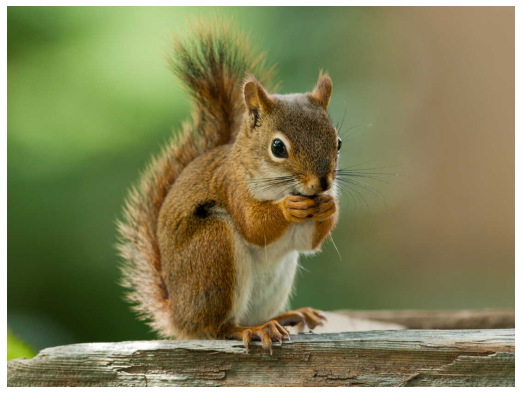

In [ ]:
# Original image
response = requests.get('https://media.npr.org/assets/img/2017/04/25/istock-115796521-fcf434f36d3d0865301cdcb9c996cfd80578ca99-s1100-c50.jpg')
# response = requests.get('https://www.mammal.org.uk/wp-content/uploads/2021/09/gsq-300x300.jpg')
img = Image.open(BytesIO(response.content))
plt.imshow(img)
plt.axis(False);

In [ ]:
%%writefile parallel_loop_shift.py

import numpy as np
import time
from mpi4py import MPI

from PIL import Image
import requests
from io import BytesIO
import tracemalloc

from tqdm.notebook import tqdm

tracemalloc.start()

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

calc_t = time.time()
mpi_wall_t = MPI.Wtime()

response = requests.get('https://media.npr.org/assets/img/2017/04/25/istock-115796521-fcf434f36d3d0865301cdcb9c996cfd80578ca99-s1100-c50.jpg')
# response = requests.get('https://www.mammal.org.uk/wp-content/uploads/2021/09/gsq-300x300.jpg')
img = Image.open(BytesIO(response.content))

img = np.asarray(img)
width = img.shape[1]
shift_step = 200

width_per_rank = np.array_split(np.arange(width), size)
width_local = width_per_rank[rank]
assert(width_local.shape[0] > shift_step)

img_local = img[:, width_local, :].copy()
tmp_columns = img_local[:, -shift_step:, :].copy()
img_local[:, shift_step:, :] = img_local[:, :-shift_step, :].copy()

comm.Sendrecv_replace([tmp_columns, MPI.FLOAT], dest=(rank+1)%size, sendtag=0,
                      source=(rank-1)%size, recvtag=0)

img_local[:, :shift_step, :] = tmp_columns
calc_t = time.time() - calc_t

img_shifted = comm.gather(img_local, root=0)

mpi_wall_t = MPI.Wtime() - mpi_wall_t

ram_usage = tracemalloc.get_traced_memory()[1]
tracemalloc.stop()

if rank == 0:
    img_shifted = np.concatenate(img_shifted, axis=1)
    np.savez('result_' + str(size) + '.npz', arr_0=img_shifted, calc_t=calc_t, mpi_wall_t=mpi_wall_t,
             ram_usage=ram_usage)

Overwriting parallel_loop_shift.py


In [ ]:
!mpirun --allow-run-as-root -n 1 python parallel_loop_shift.py

In [ ]:
!mpirun --allow-run-as-root -n 2 python parallel_loop_shift.py

In [ ]:
!mpirun --allow-run-as-root -n 3 python parallel_loop_shift.py

In [ ]:
!mpirun --allow-run-as-root -n 4 python parallel_loop_shift.py

In [ ]:
!mpirun --allow-run-as-root -n 5 python parallel_loop_shift.py

In [ ]:
!mpirun --allow-run-as-root -n 6 python parallel_loop_shift.py

In [ ]:
!mpirun --allow-run-as-root -n 7 python parallel_loop_shift.py

In [ ]:
!mpirun --allow-run-as-root -n 8 python parallel_loop_shift.py

In [ ]:
!mpirun --allow-run-as-root -n 9 python parallel_loop_shift.py

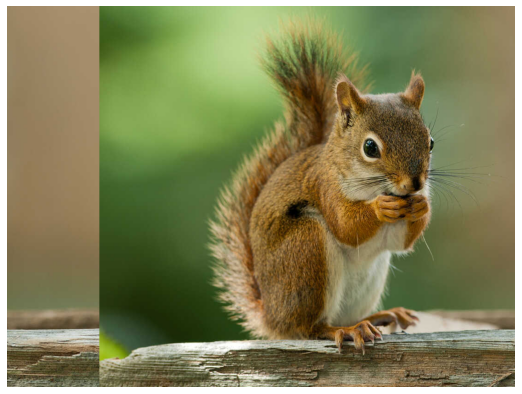

In [ ]:
source = np.load('result_4.npz')
img_shifted = Image.fromarray(source['arr_0'])
plt.imshow(img_shifted)
plt.axis(False);

## Speedup

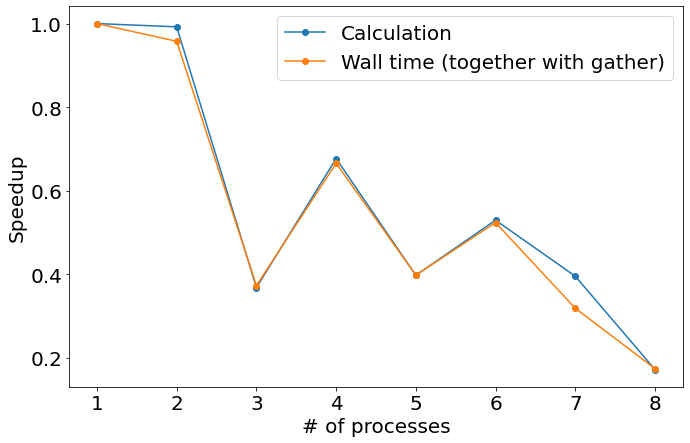

In [ ]:
calc_t = np.array([])
mpi_wall_t = np.array([])

for i in range(1, 9):
    source = np.load('result_' + str(i) + '.npz')
    calc_t = np.append(calc_t, source['calc_t'])
    mpi_wall_t = np.append(mpi_wall_t, source['mpi_wall_t'])

_, axes = plt.subplots(1, 1, figsize=(11, 7))

axes.plot(range(1, 9), calc_t[0] / calc_t, '-o', label='Calculation')
axes.plot(range(1, 9), mpi_wall_t[0] / mpi_wall_t, '-o', label='Wall time (together with gather)')

axes.set_xlabel('# of processes')
axes.set_ylabel('Speedup')
axes.legend();

## Memory consumption

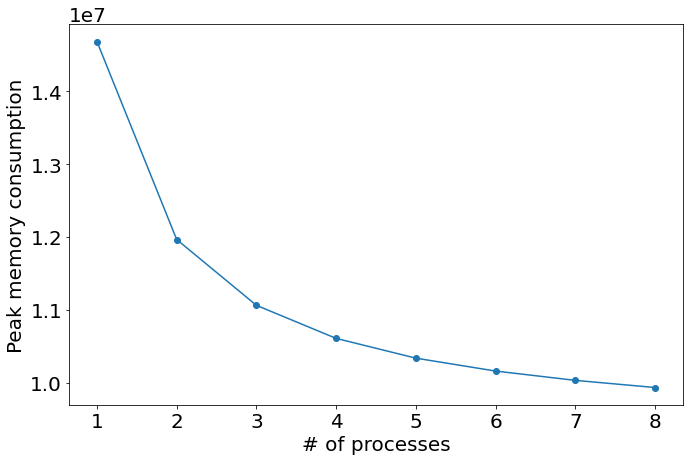

In [ ]:
ram_usage = np.array([])
for i in range(1, 9):
    source = np.load('result_' + str(i) + '.npz')
    ram_usage = np.append(ram_usage, source['ram_usage'])

_, axes = plt.subplots(1, 1, figsize=(11, 7))

axes.plot(range(1, 9), ram_usage, '-o')

axes.set_xlabel('# of processes')
axes.set_ylabel('Peak memory consumption');